In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()

import numpy
import tensorflow
import tensorflow.keras as keras
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GlobalMaxPool2D, GlobalAveragePooling2D, BatchNormalization, SpatialDropout2D, LeakyReLU, Conv2D, AveragePooling2D, Dropout, Flatten, Lambda, Dense, MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(1)


Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22#43#22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14#28#14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16#32#16
        self.data_dir = 'E:\Skelnet2D\data\SHREC\\'
C = Config()

In [4]:
# model
dropout_probability = 0.1
duration = 32
n_classes = 14
n_channels = 22  # usually  n_channels = 2 * n_joints  or  n_channels = 3 * n_joints
filters = 64

In [5]:
def c2D(x,filters,kernel):
    x = Conv2D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = SpatialDropout2D(dropout_probability)(x)
    return x

def block(x,filters):
    x = c2D(x,filters,3)
    x = c2D(x,filters,3)
    return x
    
def d2D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

In [6]:
def create_model(n_classes, duration, n_channels, dropout_probability=0.2):
    model_input = Input(shape=(duration, n_channels,3))
    
    high = c2D(model_input, filters*2,7)
    high = MaxPooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = MaxPooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = MaxPooling2D((2, 2), padding='same')(high)
    
    low = c2D(model_input, filters*2,3)
    low = MaxPooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = MaxPooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = MaxPooling2D((2, 2), padding='same')(low)
    
    ap_residual = MaxPooling2D((2, 2), padding='same', input_shape=(32,n_channels, 1))(model_input)
    ap_residual = MaxPooling2D((2, 2), padding='same')(ap_residual)
    ap_residual = MaxPooling2D((2, 2), padding='same')(ap_residual)
    
    channel_output = concatenate([low,high,ap_residual])
    features = block(channel_output,filters*2)
    features = block(channel_output,filters*2)
    features = GlobalMaxPool2D()(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    model_output = Dense(units=n_classes, activation='softmax')(features)
        
    model = Model(inputs=[model_input], outputs=[model_output])
    return model

In [7]:
model = create_model(n_classes=n_classes, duration=duration, n_channels=n_channels, dropout_probability=dropout_probability)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 22, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 22, 128)  3456        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 22, 128)  18816       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 32, 22, 128)  512         conv2d_3[0][0]                   
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 4, 3, 128)    147456      spatial_dropout2d_8[0][0]        
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 4, 3, 128)    512         conv2d_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 4, 3, 128)    0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
spatial_dropout2d_9 (SpatialDro (None, 4, 3, 128)    0           leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 128)          0           spatial_dropout2d_9[0][0]        
__________

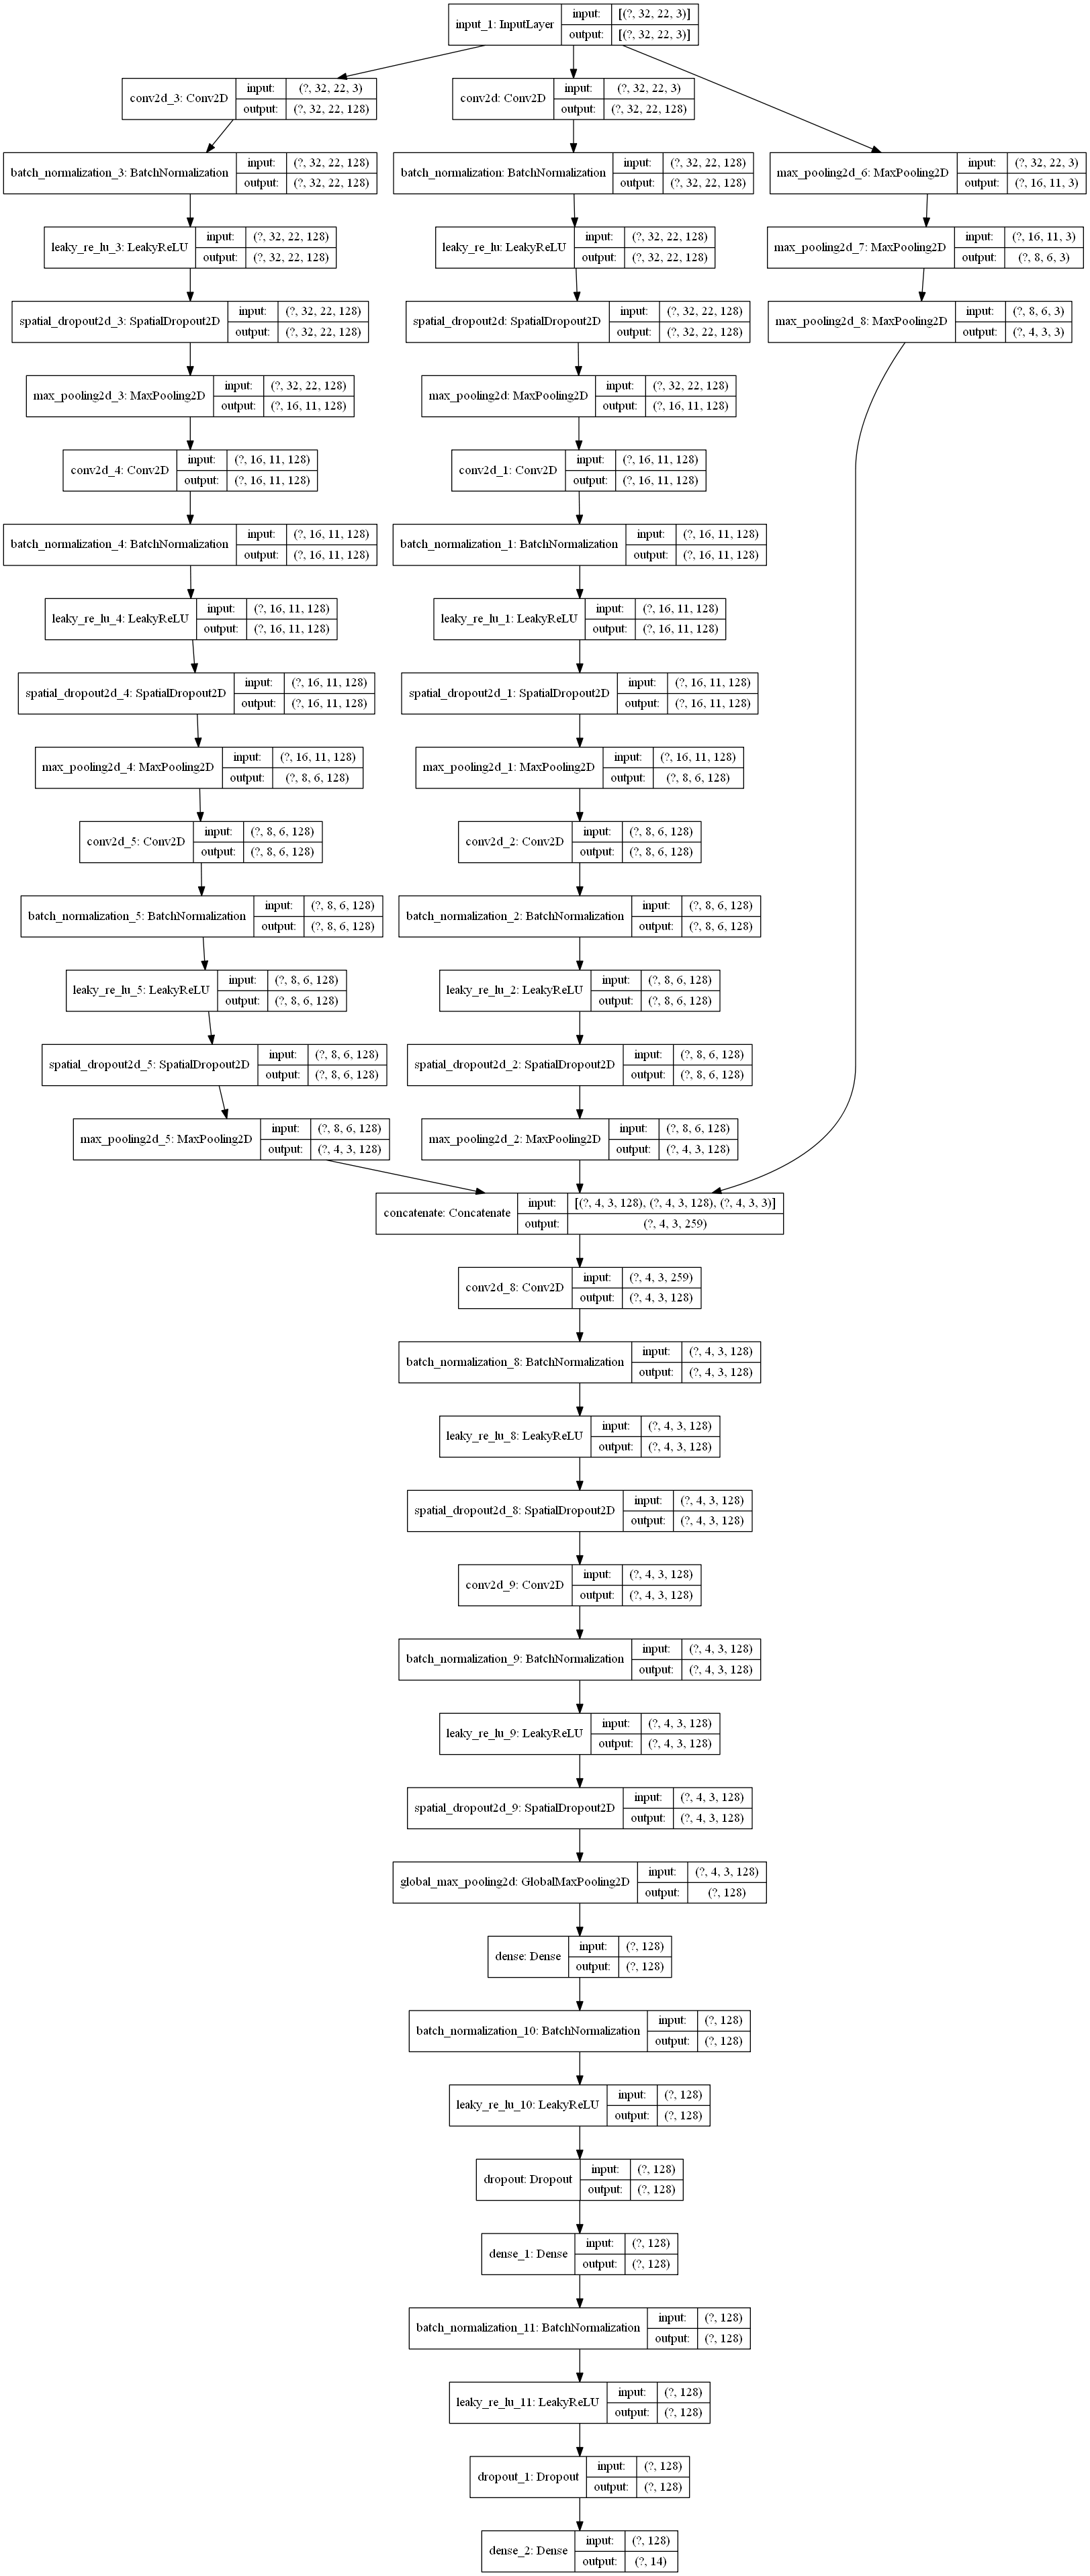

In [9]:
plot_model(model, to_file='model.png', show_shapes=True)

In [10]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

In [11]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

  1%|▊                                                                              | 20/1960 [00:00<00:09, 197.83it/s]C:\Users\Joseph\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|█████████████████████████████████████████████████████████████████████████████| 1960/1960 [00:09<00:00, 209.35it/s]


In [12]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|███████████████████████████████████████████████████████████████████████████████| 840/840 [00:04<00:00, 208.27it/s]


In [13]:
"""blank = X_1
blank_test = X_test_1
blank = np.zeros((1960,32,43,3))
blank_test = np.zeros((840,32,43,3))
list = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]
count = 0
for i in range(0,X_1.shape[0]):
    for j in range(0, X_1.shape[1]):
        count = 0
        for k in list:
            blank[i][j][count] = X_1[i][j][k-1]
            count = count + 1
count = 0
for i in range(0, X_test_1.shape[0]):
    for j in range(0, X_test_1.shape[1]):
        count = 0
        for k in list:
            blank_test[i][j][count] = X_test_1[i][j][k-1]
            count = count + 1
X_1 = blank
X_test_1 = blank_test"""

'blank = X_1\nblank_test = X_test_1\nblank = np.zeros((1960,32,43,3))\nblank_test = np.zeros((840,32,43,3))\nlist = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]\ncount = 0\nfor i in range(0,X_1.shape[0]):\n    for j in range(0, X_1.shape[1]):\n        count = 0\n        for k in list:\n            blank[i][j][count] = X_1[i][j][k-1]\n            count = count + 1\ncount = 0\nfor i in range(0, X_test_1.shape[0]):\n    for j in range(0, X_test_1.shape[1]):\n        count = 0\n        for k in list:\n            blank_test[i][j][count] = X_test_1[i][j][k-1]\n            count = count + 1\nX_1 = blank\nX_test_1 = blank_test'

In [14]:
# Training: Optimizer's Learning Rate
learning_rate = 0.001

# We use Adam to optimize a multi-class classification task
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [15]:
# Start the training

# ...with an existing validation set:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=1e-8)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model_Skel2D.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
history = model.fit(X_1, Y, validation_data=(X_test_1, Y_test), epochs=10000, batch_size=32, callbacks=[reduce_lr,es,mc])

# ...or, if there is no validation set:
# history = model.fit(x_train, y_train, validation_split=0.33, epochs=100, batch_size=32)

Train on 1960 samples, validate on 840 samples
Epoch 1/10000
1952/1960 [============================>.] - ETA: 1:46 - loss: 3.0554 - acc: 0.062 - ETA: 1:00 - loss: 2.7959 - acc: 0.171 - ETA: 44s - loss: 2.7203 - acc: 0.177 - ETA: 36s - loss: 2.6634 - acc: 0.17 - ETA: 31s - loss: 2.5481 - acc: 0.20 - ETA: 28s - loss: 2.4784 - acc: 0.20 - ETA: 25s - loss: 2.4038 - acc: 0.22 - ETA: 23s - loss: 2.3537 - acc: 0.24 - ETA: 22s - loss: 2.3082 - acc: 0.25 - ETA: 20s - loss: 2.2804 - acc: 0.26 - ETA: 19s - loss: 2.2290 - acc: 0.28 - ETA: 18s - loss: 2.1881 - acc: 0.29 - ETA: 18s - loss: 2.1512 - acc: 0.30 - ETA: 17s - loss: 2.1331 - acc: 0.30 - ETA: 16s - loss: 2.1258 - acc: 0.31 - ETA: 15s - loss: 2.1108 - acc: 0.32 - ETA: 15s - loss: 2.0782 - acc: 0.33 - ETA: 14s - loss: 2.0464 - acc: 0.34 - ETA: 14s - loss: 2.0132 - acc: 0.36 - ETA: 13s - loss: 1.9785 - acc: 0.36 - ETA: 13s - loss: 1.9509 - acc: 0.37 - ETA: 12s - loss: 1.9264 - acc: 0.38 - ETA: 12s - loss: 1.9066 - acc: 0.38 - ETA: 11s - loss

1952/1960 [============================>.] - ETA: 16s - loss: 0.3774 - acc: 0.87 - ETA: 15s - loss: 0.3272 - acc: 0.90 - ETA: 15s - loss: 0.3266 - acc: 0.90 - ETA: 14s - loss: 0.3038 - acc: 0.91 - ETA: 14s - loss: 0.3007 - acc: 0.91 - ETA: 14s - loss: 0.3274 - acc: 0.91 - ETA: 14s - loss: 0.3239 - acc: 0.91 - ETA: 13s - loss: 0.3233 - acc: 0.91 - ETA: 13s - loss: 0.3265 - acc: 0.90 - ETA: 13s - loss: 0.3202 - acc: 0.90 - ETA: 13s - loss: 0.3029 - acc: 0.90 - ETA: 12s - loss: 0.3120 - acc: 0.90 - ETA: 12s - loss: 0.3154 - acc: 0.90 - ETA: 12s - loss: 0.3171 - acc: 0.90 - ETA: 12s - loss: 0.3183 - acc: 0.90 - ETA: 11s - loss: 0.3098 - acc: 0.91 - ETA: 11s - loss: 0.3139 - acc: 0.91 - ETA: 11s - loss: 0.3056 - acc: 0.91 - ETA: 10s - loss: 0.3033 - acc: 0.91 - ETA: 10s - loss: 0.3087 - acc: 0.91 - ETA: 10s - loss: 0.3018 - acc: 0.91 - ETA: 10s - loss: 0.3105 - acc: 0.91 - ETA: 9s - loss: 0.3039 - acc: 0.9171 - ETA: 9s - loss: 0.3024 - acc: 0.916 - ETA: 9s - loss: 0.3024 - acc: 0.917 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.1907 - acc: 0.93 - ETA: 15s - loss: 0.1824 - acc: 0.93 - ETA: 15s - loss: 0.2348 - acc: 0.92 - ETA: 14s - loss: 0.2134 - acc: 0.92 - ETA: 14s - loss: 0.2457 - acc: 0.93 - ETA: 14s - loss: 0.2628 - acc: 0.92 - ETA: 14s - loss: 0.2915 - acc: 0.91 - ETA: 13s - loss: 0.3169 - acc: 0.90 - ETA: 13s - loss: 0.3088 - acc: 0.90 - ETA: 13s - loss: 0.2987 - acc: 0.90 - ETA: 13s - loss: 0.2903 - acc: 0.91 - ETA: 12s - loss: 0.2889 - acc: 0.91 - ETA: 12s - loss: 0.2811 - acc: 0.91 - ETA: 12s - loss: 0.2905 - acc: 0.91 - ETA: 11s - loss: 0.2866 - acc: 0.91 - ETA: 11s - loss: 0.2880 - acc: 0.91 - ETA: 11s - loss: 0.2855 - acc: 0.91 - ETA: 11s - loss: 0.2730 - acc: 0.91 - ETA: 10s - loss: 0.2660 - acc: 0.91 - ETA: 10s - loss: 0.2678 - acc: 0.91 - ETA: 10s - loss: 0.2645 - acc: 0.91 - ETA: 10s - loss: 0.2678 - acc: 0.91 - ETA: 9s - loss: 0.2684 - acc: 0.9185 - ETA: 9s - loss: 0.2617 - acc: 0.920 - ETA: 9s - loss: 0.2594 - acc: 0.921 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.1507 - acc: 0.93 - ETA: 15s - loss: 0.0914 - acc: 0.96 - ETA: 15s - loss: 0.0793 - acc: 0.97 - ETA: 14s - loss: 0.1055 - acc: 0.96 - ETA: 14s - loss: 0.1325 - acc: 0.96 - ETA: 14s - loss: 0.1540 - acc: 0.95 - ETA: 14s - loss: 0.1672 - acc: 0.95 - ETA: 13s - loss: 0.1654 - acc: 0.94 - ETA: 13s - loss: 0.1665 - acc: 0.94 - ETA: 13s - loss: 0.1742 - acc: 0.94 - ETA: 13s - loss: 0.1785 - acc: 0.94 - ETA: 12s - loss: 0.1704 - acc: 0.94 - ETA: 12s - loss: 0.1701 - acc: 0.94 - ETA: 12s - loss: 0.1722 - acc: 0.94 - ETA: 11s - loss: 0.1852 - acc: 0.93 - ETA: 11s - loss: 0.1917 - acc: 0.93 - ETA: 11s - loss: 0.1879 - acc: 0.93 - ETA: 11s - loss: 0.1918 - acc: 0.93 - ETA: 10s - loss: 0.1978 - acc: 0.93 - ETA: 10s - loss: 0.2018 - acc: 0.93 - ETA: 10s - loss: 0.2156 - acc: 0.92 - ETA: 10s - loss: 0.2106 - acc: 0.92 - ETA: 9s - loss: 0.2124 - acc: 0.9280 - ETA: 9s - loss: 0.2093 - acc: 0.929 - ETA: 9s - loss: 0.2213 - acc: 0.926 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0932 - acc: 0.96 - ETA: 15s - loss: 0.0863 - acc: 0.96 - ETA: 14s - loss: 0.0965 - acc: 0.96 - ETA: 14s - loss: 0.0914 - acc: 0.97 - ETA: 14s - loss: 0.0865 - acc: 0.98 - ETA: 14s - loss: 0.0910 - acc: 0.97 - ETA: 14s - loss: 0.1311 - acc: 0.95 - ETA: 13s - loss: 0.1326 - acc: 0.95 - ETA: 13s - loss: 0.1337 - acc: 0.95 - ETA: 13s - loss: 0.1242 - acc: 0.95 - ETA: 12s - loss: 0.1251 - acc: 0.96 - ETA: 12s - loss: 0.1408 - acc: 0.95 - ETA: 12s - loss: 0.1371 - acc: 0.95 - ETA: 12s - loss: 0.1409 - acc: 0.95 - ETA: 11s - loss: 0.1409 - acc: 0.96 - ETA: 11s - loss: 0.1420 - acc: 0.95 - ETA: 11s - loss: 0.1453 - acc: 0.95 - ETA: 11s - loss: 0.1493 - acc: 0.95 - ETA: 10s - loss: 0.1466 - acc: 0.95 - ETA: 10s - loss: 0.1423 - acc: 0.95 - ETA: 10s - loss: 0.1431 - acc: 0.95 - ETA: 10s - loss: 0.1380 - acc: 0.96 - ETA: 9s - loss: 0.1339 - acc: 0.9606 - ETA: 9s - loss: 0.1357 - acc: 0.959 - ETA: 9s - loss: 0.1341 - acc: 0.960 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.0218 - acc: 1.00 - ETA: 15s - loss: 0.0266 - acc: 1.00 - ETA: 15s - loss: 0.0558 - acc: 0.97 - ETA: 14s - loss: 0.1366 - acc: 0.96 - ETA: 14s - loss: 0.1280 - acc: 0.96 - ETA: 14s - loss: 0.1193 - acc: 0.97 - ETA: 13s - loss: 0.1197 - acc: 0.97 - ETA: 13s - loss: 0.1092 - acc: 0.97 - ETA: 13s - loss: 0.1063 - acc: 0.97 - ETA: 13s - loss: 0.1145 - acc: 0.97 - ETA: 12s - loss: 0.1077 - acc: 0.97 - ETA: 12s - loss: 0.1093 - acc: 0.97 - ETA: 12s - loss: 0.1116 - acc: 0.97 - ETA: 12s - loss: 0.1135 - acc: 0.97 - ETA: 12s - loss: 0.1119 - acc: 0.97 - ETA: 11s - loss: 0.1128 - acc: 0.97 - ETA: 11s - loss: 0.1073 - acc: 0.97 - ETA: 11s - loss: 0.1060 - acc: 0.97 - ETA: 11s - loss: 0.1065 - acc: 0.97 - ETA: 10s - loss: 0.1077 - acc: 0.97 - ETA: 10s - loss: 0.1048 - acc: 0.97 - ETA: 10s - loss: 0.1010 - acc: 0.97 - ETA: 9s - loss: 0.1043 - acc: 0.9715 - ETA: 9s - loss: 0.1024 - acc: 0.972 - ETA: 9s - loss: 0.1036 - acc: 0.971 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0448 - acc: 1.00 - ETA: 15s - loss: 0.0971 - acc: 0.98 - ETA: 14s - loss: 0.1265 - acc: 0.96 - ETA: 14s - loss: 0.1032 - acc: 0.97 - ETA: 14s - loss: 0.1186 - acc: 0.97 - ETA: 14s - loss: 0.1113 - acc: 0.97 - ETA: 13s - loss: 0.1213 - acc: 0.97 - ETA: 13s - loss: 0.1127 - acc: 0.97 - ETA: 13s - loss: 0.1039 - acc: 0.97 - ETA: 13s - loss: 0.1020 - acc: 0.97 - ETA: 12s - loss: 0.0949 - acc: 0.97 - ETA: 12s - loss: 0.0923 - acc: 0.97 - ETA: 12s - loss: 0.0918 - acc: 0.97 - ETA: 12s - loss: 0.0884 - acc: 0.97 - ETA: 11s - loss: 0.0846 - acc: 0.98 - ETA: 11s - loss: 0.0816 - acc: 0.98 - ETA: 11s - loss: 0.0805 - acc: 0.98 - ETA: 11s - loss: 0.0801 - acc: 0.98 - ETA: 10s - loss: 0.0802 - acc: 0.97 - ETA: 10s - loss: 0.0801 - acc: 0.97 - ETA: 10s - loss: 0.0775 - acc: 0.97 - ETA: 10s - loss: 0.0750 - acc: 0.98 - ETA: 9s - loss: 0.0743 - acc: 0.9810 - ETA: 9s - loss: 0.0736 - acc: 0.980 - ETA: 9s - loss: 0.0717 - acc: 0.981 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0312 - acc: 1.00 - ETA: 15s - loss: 0.1049 - acc: 0.96 - ETA: 15s - loss: 0.2299 - acc: 0.94 - ETA: 14s - loss: 0.1746 - acc: 0.96 - ETA: 14s - loss: 0.1728 - acc: 0.95 - ETA: 14s - loss: 0.1466 - acc: 0.96 - ETA: 13s - loss: 0.1352 - acc: 0.96 - ETA: 13s - loss: 0.1214 - acc: 0.96 - ETA: 13s - loss: 0.1100 - acc: 0.97 - ETA: 13s - loss: 0.1028 - acc: 0.97 - ETA: 12s - loss: 0.0947 - acc: 0.97 - ETA: 12s - loss: 0.0901 - acc: 0.97 - ETA: 12s - loss: 0.0884 - acc: 0.97 - ETA: 12s - loss: 0.0946 - acc: 0.97 - ETA: 11s - loss: 0.0916 - acc: 0.97 - ETA: 11s - loss: 0.0947 - acc: 0.97 - ETA: 11s - loss: 0.0929 - acc: 0.97 - ETA: 11s - loss: 0.0901 - acc: 0.97 - ETA: 10s - loss: 0.0905 - acc: 0.97 - ETA: 10s - loss: 0.0893 - acc: 0.97 - ETA: 10s - loss: 0.0937 - acc: 0.97 - ETA: 10s - loss: 0.0942 - acc: 0.97 - ETA: 9s - loss: 0.0932 - acc: 0.9742 - ETA: 9s - loss: 0.0930 - acc: 0.974 - ETA: 9s - loss: 0.0934 - acc: 0.972 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0533 - acc: 1.00 - ETA: 15s - loss: 0.0308 - acc: 1.00 - ETA: 14s - loss: 0.0270 - acc: 1.00 - ETA: 14s - loss: 0.0244 - acc: 1.00 - ETA: 14s - loss: 0.0712 - acc: 0.98 - ETA: 14s - loss: 0.0675 - acc: 0.97 - ETA: 13s - loss: 0.0603 - acc: 0.98 - ETA: 13s - loss: 0.0570 - acc: 0.98 - ETA: 13s - loss: 0.0775 - acc: 0.97 - ETA: 13s - loss: 0.0734 - acc: 0.98 - ETA: 12s - loss: 0.0700 - acc: 0.98 - ETA: 12s - loss: 0.0657 - acc: 0.98 - ETA: 12s - loss: 0.0667 - acc: 0.98 - ETA: 12s - loss: 0.0630 - acc: 0.98 - ETA: 11s - loss: 0.0654 - acc: 0.98 - ETA: 11s - loss: 0.0622 - acc: 0.98 - ETA: 11s - loss: 0.0593 - acc: 0.98 - ETA: 11s - loss: 0.0619 - acc: 0.98 - ETA: 10s - loss: 0.0712 - acc: 0.97 - ETA: 10s - loss: 0.0688 - acc: 0.97 - ETA: 10s - loss: 0.0693 - acc: 0.97 - ETA: 10s - loss: 0.0668 - acc: 0.97 - ETA: 9s - loss: 0.0644 - acc: 0.9783 - ETA: 9s - loss: 0.0677 - acc: 0.977 - ETA: 9s - loss: 0.0732 - acc: 0.976 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0293 - acc: 1.00 - ETA: 15s - loss: 0.0840 - acc: 0.98 - ETA: 15s - loss: 0.0696 - acc: 0.97 - ETA: 15s - loss: 0.0676 - acc: 0.97 - ETA: 15s - loss: 0.0555 - acc: 0.98 - ETA: 14s - loss: 0.0476 - acc: 0.98 - ETA: 14s - loss: 0.0494 - acc: 0.98 - ETA: 14s - loss: 0.0443 - acc: 0.98 - ETA: 13s - loss: 0.0417 - acc: 0.98 - ETA: 13s - loss: 0.0421 - acc: 0.98 - ETA: 13s - loss: 0.0543 - acc: 0.98 - ETA: 13s - loss: 0.0549 - acc: 0.98 - ETA: 12s - loss: 0.0815 - acc: 0.97 - ETA: 12s - loss: 0.0806 - acc: 0.97 - ETA: 12s - loss: 0.0768 - acc: 0.97 - ETA: 12s - loss: 0.0731 - acc: 0.98 - ETA: 11s - loss: 0.0699 - acc: 0.98 - ETA: 11s - loss: 0.0672 - acc: 0.98 - ETA: 11s - loss: 0.0660 - acc: 0.98 - ETA: 10s - loss: 0.0636 - acc: 0.98 - ETA: 10s - loss: 0.0718 - acc: 0.98 - ETA: 10s - loss: 0.0702 - acc: 0.98 - ETA: 10s - loss: 0.0694 - acc: 0.98 - ETA: 9s - loss: 0.0670 - acc: 0.9818 - ETA: 9s - loss: 0.0757 - acc: 0.978 - ETA:

1952/1960 [============================>.] - ETA: 17s - loss: 0.0078 - acc: 1.00 - ETA: 16s - loss: 0.0084 - acc: 1.00 - ETA: 16s - loss: 0.0107 - acc: 1.00 - ETA: 15s - loss: 0.0159 - acc: 1.00 - ETA: 15s - loss: 0.0492 - acc: 0.99 - ETA: 15s - loss: 0.0623 - acc: 0.98 - ETA: 14s - loss: 0.0585 - acc: 0.98 - ETA: 14s - loss: 0.0545 - acc: 0.98 - ETA: 14s - loss: 0.0543 - acc: 0.98 - ETA: 13s - loss: 0.0497 - acc: 0.99 - ETA: 13s - loss: 0.0462 - acc: 0.99 - ETA: 13s - loss: 0.0454 - acc: 0.98 - ETA: 12s - loss: 0.0440 - acc: 0.99 - ETA: 12s - loss: 0.0436 - acc: 0.99 - ETA: 12s - loss: 0.0495 - acc: 0.98 - ETA: 12s - loss: 0.0498 - acc: 0.99 - ETA: 11s - loss: 0.0487 - acc: 0.99 - ETA: 11s - loss: 0.0469 - acc: 0.99 - ETA: 11s - loss: 0.0450 - acc: 0.99 - ETA: 11s - loss: 0.0496 - acc: 0.99 - ETA: 10s - loss: 0.0484 - acc: 0.99 - ETA: 10s - loss: 0.0500 - acc: 0.99 - ETA: 10s - loss: 0.0484 - acc: 0.99 - ETA: 10s - loss: 0.0472 - acc: 0.99 - ETA: 9s - loss: 0.0509 - acc: 0.9887 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.0231 - acc: 1.00 - ETA: 15s - loss: 0.0139 - acc: 1.00 - ETA: 15s - loss: 0.0268 - acc: 0.98 - ETA: 15s - loss: 0.0297 - acc: 0.98 - ETA: 15s - loss: 0.0248 - acc: 0.98 - ETA: 14s - loss: 0.0224 - acc: 0.98 - ETA: 14s - loss: 0.0214 - acc: 0.99 - ETA: 14s - loss: 0.0197 - acc: 0.99 - ETA: 14s - loss: 0.0179 - acc: 0.99 - ETA: 13s - loss: 0.0165 - acc: 0.99 - ETA: 13s - loss: 0.0163 - acc: 0.99 - ETA: 13s - loss: 0.0152 - acc: 0.99 - ETA: 12s - loss: 0.0181 - acc: 0.99 - ETA: 12s - loss: 0.0218 - acc: 0.99 - ETA: 12s - loss: 0.0218 - acc: 0.99 - ETA: 12s - loss: 0.0211 - acc: 0.99 - ETA: 12s - loss: 0.0202 - acc: 0.99 - ETA: 11s - loss: 0.0196 - acc: 0.99 - ETA: 11s - loss: 0.0193 - acc: 0.99 - ETA: 11s - loss: 0.0186 - acc: 0.99 - ETA: 10s - loss: 0.0180 - acc: 0.99 - ETA: 10s - loss: 0.0180 - acc: 0.99 - ETA: 10s - loss: 0.0177 - acc: 0.99 - ETA: 10s - loss: 0.0177 - acc: 0.99 - ETA: 9s - loss: 0.0179 - acc: 0.9962 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0289 - acc: 1.00 - ETA: 14s - loss: 0.0312 - acc: 0.98 - ETA: 14s - loss: 0.0243 - acc: 0.98 - ETA: 14s - loss: 0.0212 - acc: 0.99 - ETA: 14s - loss: 0.0186 - acc: 0.99 - ETA: 13s - loss: 0.0166 - acc: 0.99 - ETA: 13s - loss: 0.0150 - acc: 0.99 - ETA: 13s - loss: 0.0144 - acc: 0.99 - ETA: 13s - loss: 0.0137 - acc: 0.99 - ETA: 12s - loss: 0.0128 - acc: 0.99 - ETA: 12s - loss: 0.0122 - acc: 0.99 - ETA: 12s - loss: 0.0129 - acc: 0.99 - ETA: 12s - loss: 0.0131 - acc: 0.99 - ETA: 11s - loss: 0.0125 - acc: 0.99 - ETA: 11s - loss: 0.0119 - acc: 0.99 - ETA: 11s - loss: 0.0117 - acc: 0.99 - ETA: 11s - loss: 0.0113 - acc: 0.99 - ETA: 11s - loss: 0.0118 - acc: 0.99 - ETA: 10s - loss: 0.0117 - acc: 0.99 - ETA: 10s - loss: 0.0122 - acc: 0.99 - ETA: 10s - loss: 0.0118 - acc: 0.99 - ETA: 10s - loss: 0.0115 - acc: 0.99 - ETA: 9s - loss: 0.0113 - acc: 0.9986 - ETA: 9s - loss: 0.0117 - acc: 0.998 - ETA: 9s - loss: 0.0156 - acc: 0.997 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0067 - acc: 1.00 - ETA: 15s - loss: 0.0161 - acc: 1.00 - ETA: 15s - loss: 0.0120 - acc: 1.00 - ETA: 15s - loss: 0.0097 - acc: 1.00 - ETA: 15s - loss: 0.0101 - acc: 1.00 - ETA: 15s - loss: 0.0253 - acc: 0.99 - ETA: 15s - loss: 0.0256 - acc: 0.99 - ETA: 14s - loss: 0.0243 - acc: 0.99 - ETA: 14s - loss: 0.0472 - acc: 0.98 - ETA: 14s - loss: 0.0431 - acc: 0.99 - ETA: 13s - loss: 0.0401 - acc: 0.99 - ETA: 13s - loss: 0.0369 - acc: 0.99 - ETA: 13s - loss: 0.0414 - acc: 0.99 - ETA: 12s - loss: 0.0393 - acc: 0.99 - ETA: 12s - loss: 0.0381 - acc: 0.99 - ETA: 12s - loss: 0.0362 - acc: 0.99 - ETA: 11s - loss: 0.0346 - acc: 0.99 - ETA: 11s - loss: 0.0342 - acc: 0.99 - ETA: 11s - loss: 0.0331 - acc: 0.99 - ETA: 11s - loss: 0.0316 - acc: 0.99 - ETA: 10s - loss: 0.0304 - acc: 0.99 - ETA: 10s - loss: 0.0292 - acc: 0.99 - ETA: 10s - loss: 0.0283 - acc: 0.99 - ETA: 10s - loss: 0.0275 - acc: 0.99 - ETA: 9s - loss: 0.0272 - acc: 0.9950 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.0167 - acc: 1.00 - ETA: 17s - loss: 0.0104 - acc: 1.00 - ETA: 16s - loss: 0.0081 - acc: 1.00 - ETA: 16s - loss: 0.0075 - acc: 1.00 - ETA: 15s - loss: 0.0067 - acc: 1.00 - ETA: 15s - loss: 0.0398 - acc: 0.99 - ETA: 14s - loss: 0.0528 - acc: 0.99 - ETA: 14s - loss: 0.0473 - acc: 0.99 - ETA: 14s - loss: 0.0632 - acc: 0.98 - ETA: 13s - loss: 0.0573 - acc: 0.98 - ETA: 13s - loss: 0.0528 - acc: 0.98 - ETA: 13s - loss: 0.0747 - acc: 0.98 - ETA: 13s - loss: 0.0796 - acc: 0.98 - ETA: 12s - loss: 0.0743 - acc: 0.98 - ETA: 12s - loss: 0.0695 - acc: 0.98 - ETA: 12s - loss: 0.0742 - acc: 0.98 - ETA: 11s - loss: 0.0702 - acc: 0.98 - ETA: 11s - loss: 0.0682 - acc: 0.98 - ETA: 11s - loss: 0.0654 - acc: 0.98 - ETA: 11s - loss: 0.0623 - acc: 0.98 - ETA: 10s - loss: 0.0600 - acc: 0.98 - ETA: 10s - loss: 0.0576 - acc: 0.98 - ETA: 10s - loss: 0.0553 - acc: 0.98 - ETA: 9s - loss: 0.0544 - acc: 0.9857 - ETA: 9s - loss: 0.0528 - acc: 0.986 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0020 - acc: 1.00 - ETA: 15s - loss: 0.0037 - acc: 1.00 - ETA: 14s - loss: 0.0043 - acc: 1.00 - ETA: 14s - loss: 0.0046 - acc: 1.00 - ETA: 14s - loss: 0.0043 - acc: 1.00 - ETA: 14s - loss: 0.0042 - acc: 1.00 - ETA: 13s - loss: 0.0054 - acc: 1.00 - ETA: 13s - loss: 0.0048 - acc: 1.00 - ETA: 13s - loss: 0.0046 - acc: 1.00 - ETA: 13s - loss: 0.0050 - acc: 1.00 - ETA: 12s - loss: 0.0051 - acc: 1.00 - ETA: 12s - loss: 0.0060 - acc: 1.00 - ETA: 12s - loss: 0.0057 - acc: 1.00 - ETA: 12s - loss: 0.0061 - acc: 1.00 - ETA: 11s - loss: 0.0062 - acc: 1.00 - ETA: 11s - loss: 0.0061 - acc: 1.00 - ETA: 11s - loss: 0.0065 - acc: 1.00 - ETA: 11s - loss: 0.0065 - acc: 1.00 - ETA: 10s - loss: 0.0105 - acc: 0.99 - ETA: 10s - loss: 0.0115 - acc: 0.99 - ETA: 10s - loss: 0.0111 - acc: 0.99 - ETA: 10s - loss: 0.0107 - acc: 0.99 - ETA: 9s - loss: 0.0106 - acc: 0.9986 - ETA: 9s - loss: 0.0103 - acc: 0.998 - ETA: 9s - loss: 0.0100 - acc: 0.998 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.0042 - acc: 1.00 - ETA: 16s - loss: 0.0044 - acc: 1.00 - ETA: 15s - loss: 0.0078 - acc: 1.00 - ETA: 16s - loss: 0.0077 - acc: 1.00 - ETA: 15s - loss: 0.0068 - acc: 1.00 - ETA: 15s - loss: 0.0126 - acc: 0.99 - ETA: 14s - loss: 0.0115 - acc: 0.99 - ETA: 14s - loss: 0.0102 - acc: 0.99 - ETA: 14s - loss: 0.0091 - acc: 0.99 - ETA: 13s - loss: 0.0083 - acc: 0.99 - ETA: 13s - loss: 0.0077 - acc: 0.99 - ETA: 13s - loss: 0.0091 - acc: 0.99 - ETA: 13s - loss: 0.0094 - acc: 0.99 - ETA: 12s - loss: 0.0089 - acc: 0.99 - ETA: 12s - loss: 0.0084 - acc: 0.99 - ETA: 12s - loss: 0.0082 - acc: 0.99 - ETA: 12s - loss: 0.0079 - acc: 0.99 - ETA: 11s - loss: 0.0086 - acc: 0.99 - ETA: 11s - loss: 0.0168 - acc: 0.99 - ETA: 11s - loss: 0.0162 - acc: 0.99 - ETA: 10s - loss: 0.0159 - acc: 0.99 - ETA: 10s - loss: 0.0160 - acc: 0.99 - ETA: 10s - loss: 0.0154 - acc: 0.99 - ETA: 10s - loss: 0.0153 - acc: 0.99 - ETA: 9s - loss: 0.0150 - acc: 0.9962 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0054 - acc: 1.00 - ETA: 15s - loss: 0.0040 - acc: 1.00 - ETA: 14s - loss: 0.0045 - acc: 1.00 - ETA: 14s - loss: 0.0055 - acc: 1.00 - ETA: 14s - loss: 0.0064 - acc: 1.00 - ETA: 14s - loss: 0.0063 - acc: 1.00 - ETA: 13s - loss: 0.0086 - acc: 1.00 - ETA: 13s - loss: 0.0080 - acc: 1.00 - ETA: 13s - loss: 0.0073 - acc: 1.00 - ETA: 13s - loss: 0.0068 - acc: 1.00 - ETA: 12s - loss: 0.0072 - acc: 1.00 - ETA: 12s - loss: 0.0079 - acc: 1.00 - ETA: 12s - loss: 0.0084 - acc: 1.00 - ETA: 12s - loss: 0.0080 - acc: 1.00 - ETA: 11s - loss: 0.0075 - acc: 1.00 - ETA: 11s - loss: 0.0072 - acc: 1.00 - ETA: 11s - loss: 0.0070 - acc: 1.00 - ETA: 11s - loss: 0.0082 - acc: 1.00 - ETA: 10s - loss: 0.0079 - acc: 1.00 - ETA: 10s - loss: 0.0100 - acc: 0.99 - ETA: 10s - loss: 0.0097 - acc: 0.99 - ETA: 10s - loss: 0.0096 - acc: 0.99 - ETA: 9s - loss: 0.0093 - acc: 0.9986 - ETA: 9s - loss: 0.0091 - acc: 0.998 - ETA: 9s - loss: 0.0089 - acc: 0.998 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0035 - acc: 1.00 - ETA: 15s - loss: 0.0066 - acc: 1.00 - ETA: 15s - loss: 0.0049 - acc: 1.00 - ETA: 15s - loss: 0.0133 - acc: 0.99 - ETA: 14s - loss: 0.0115 - acc: 0.99 - ETA: 14s - loss: 0.0098 - acc: 0.99 - ETA: 14s - loss: 0.0124 - acc: 0.99 - ETA: 13s - loss: 0.0109 - acc: 0.99 - ETA: 13s - loss: 0.0099 - acc: 0.99 - ETA: 13s - loss: 0.0090 - acc: 0.99 - ETA: 13s - loss: 0.0087 - acc: 0.99 - ETA: 12s - loss: 0.0090 - acc: 0.99 - ETA: 12s - loss: 0.0083 - acc: 0.99 - ETA: 12s - loss: 0.0122 - acc: 0.99 - ETA: 12s - loss: 0.0116 - acc: 0.99 - ETA: 11s - loss: 0.0110 - acc: 0.99 - ETA: 11s - loss: 0.0105 - acc: 0.99 - ETA: 11s - loss: 0.0100 - acc: 0.99 - ETA: 10s - loss: 0.0096 - acc: 0.99 - ETA: 10s - loss: 0.0095 - acc: 0.99 - ETA: 10s - loss: 0.0093 - acc: 0.99 - ETA: 10s - loss: 0.0090 - acc: 0.99 - ETA: 9s - loss: 0.0090 - acc: 0.9959 - ETA: 9s - loss: 0.0088 - acc: 0.996 - ETA: 9s - loss: 0.0085 - acc: 0.996 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.0012 - acc: 1.00 - ETA: 15s - loss: 0.0050 - acc: 1.00 - ETA: 15s - loss: 0.0127 - acc: 1.00 - ETA: 15s - loss: 0.0110 - acc: 1.00 - ETA: 15s - loss: 0.0094 - acc: 1.00 - ETA: 15s - loss: 0.0080 - acc: 1.00 - ETA: 14s - loss: 0.0088 - acc: 1.00 - ETA: 14s - loss: 0.0080 - acc: 1.00 - ETA: 14s - loss: 0.0073 - acc: 1.00 - ETA: 13s - loss: 0.0123 - acc: 0.99 - ETA: 13s - loss: 0.0114 - acc: 0.99 - ETA: 13s - loss: 0.0108 - acc: 0.99 - ETA: 13s - loss: 0.0109 - acc: 0.99 - ETA: 12s - loss: 0.0102 - acc: 0.99 - ETA: 12s - loss: 0.0101 - acc: 0.99 - ETA: 12s - loss: 0.0100 - acc: 0.99 - ETA: 11s - loss: 0.0097 - acc: 0.99 - ETA: 11s - loss: 0.0092 - acc: 0.99 - ETA: 11s - loss: 0.0090 - acc: 0.99 - ETA: 11s - loss: 0.0110 - acc: 0.99 - ETA: 10s - loss: 0.0155 - acc: 0.99 - ETA: 10s - loss: 0.0148 - acc: 0.99 - ETA: 10s - loss: 0.0144 - acc: 0.99 - ETA: 10s - loss: 0.0142 - acc: 0.99 - ETA: 9s - loss: 0.0137 - acc: 0.9962 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0013 - acc: 1.00 - ETA: 15s - loss: 0.0018 - acc: 1.00 - ETA: 14s - loss: 0.0152 - acc: 0.98 - ETA: 14s - loss: 0.0133 - acc: 0.99 - ETA: 14s - loss: 0.0110 - acc: 0.99 - ETA: 14s - loss: 0.0096 - acc: 0.99 - ETA: 13s - loss: 0.0083 - acc: 0.99 - ETA: 13s - loss: 0.0091 - acc: 0.99 - ETA: 13s - loss: 0.0082 - acc: 0.99 - ETA: 13s - loss: 0.0077 - acc: 0.99 - ETA: 12s - loss: 0.0072 - acc: 0.99 - ETA: 12s - loss: 0.0072 - acc: 0.99 - ETA: 12s - loss: 0.0074 - acc: 0.99 - ETA: 12s - loss: 0.0069 - acc: 0.99 - ETA: 11s - loss: 0.0066 - acc: 0.99 - ETA: 11s - loss: 0.0068 - acc: 0.99 - ETA: 11s - loss: 0.0067 - acc: 0.99 - ETA: 11s - loss: 0.0064 - acc: 0.99 - ETA: 10s - loss: 0.0063 - acc: 0.99 - ETA: 10s - loss: 0.0061 - acc: 0.99 - ETA: 10s - loss: 0.0059 - acc: 0.99 - ETA: 10s - loss: 0.0058 - acc: 0.99 - ETA: 9s - loss: 0.0056 - acc: 0.9986 - ETA: 9s - loss: 0.0054 - acc: 0.998 - ETA: 9s - loss: 0.0055 - acc: 0.998 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0020 - acc: 1.00 - ETA: 15s - loss: 0.0028 - acc: 1.00 - ETA: 14s - loss: 0.0368 - acc: 0.98 - ETA: 14s - loss: 0.0290 - acc: 0.99 - ETA: 14s - loss: 0.0234 - acc: 0.99 - ETA: 14s - loss: 0.0246 - acc: 0.98 - ETA: 13s - loss: 0.0219 - acc: 0.99 - ETA: 13s - loss: 0.0198 - acc: 0.99 - ETA: 13s - loss: 0.0179 - acc: 0.99 - ETA: 13s - loss: 0.0164 - acc: 0.99 - ETA: 12s - loss: 0.0157 - acc: 0.99 - ETA: 12s - loss: 0.0156 - acc: 0.99 - ETA: 12s - loss: 0.0146 - acc: 0.99 - ETA: 12s - loss: 0.0159 - acc: 0.99 - ETA: 11s - loss: 0.0159 - acc: 0.99 - ETA: 11s - loss: 0.0151 - acc: 0.99 - ETA: 11s - loss: 0.0143 - acc: 0.99 - ETA: 11s - loss: 0.0136 - acc: 0.99 - ETA: 10s - loss: 0.0133 - acc: 0.99 - ETA: 10s - loss: 0.0130 - acc: 0.99 - ETA: 10s - loss: 0.0126 - acc: 0.99 - ETA: 10s - loss: 0.0121 - acc: 0.99 - ETA: 9s - loss: 0.0119 - acc: 0.9959 - ETA: 9s - loss: 0.0122 - acc: 0.996 - ETA: 9s - loss: 0.0118 - acc: 0.996 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0067 - acc: 1.00 - ETA: 15s - loss: 0.0046 - acc: 1.00 - ETA: 14s - loss: 0.0035 - acc: 1.00 - ETA: 14s - loss: 0.0031 - acc: 1.00 - ETA: 14s - loss: 0.0034 - acc: 1.00 - ETA: 14s - loss: 0.0035 - acc: 1.00 - ETA: 13s - loss: 0.0032 - acc: 1.00 - ETA: 13s - loss: 0.0046 - acc: 1.00 - ETA: 13s - loss: 0.0046 - acc: 1.00 - ETA: 13s - loss: 0.0043 - acc: 1.00 - ETA: 12s - loss: 0.0040 - acc: 1.00 - ETA: 12s - loss: 0.0040 - acc: 1.00 - ETA: 12s - loss: 0.0038 - acc: 1.00 - ETA: 12s - loss: 0.0039 - acc: 1.00 - ETA: 11s - loss: 0.0039 - acc: 1.00 - ETA: 11s - loss: 0.0037 - acc: 1.00 - ETA: 11s - loss: 0.0036 - acc: 1.00 - ETA: 11s - loss: 0.0056 - acc: 0.99 - ETA: 10s - loss: 0.0054 - acc: 0.99 - ETA: 10s - loss: 0.0052 - acc: 0.99 - ETA: 10s - loss: 0.0053 - acc: 0.99 - ETA: 10s - loss: 0.0051 - acc: 0.99 - ETA: 9s - loss: 0.0056 - acc: 0.9986 - ETA: 9s - loss: 0.0059 - acc: 0.998 - ETA: 9s - loss: 0.0064 - acc: 0.998 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0043 - acc: 1.00 - ETA: 15s - loss: 0.0028 - acc: 1.00 - ETA: 15s - loss: 0.0025 - acc: 1.00 - ETA: 15s - loss: 0.0021 - acc: 1.00 - ETA: 14s - loss: 0.0024 - acc: 1.00 - ETA: 14s - loss: 0.0021 - acc: 1.00 - ETA: 14s - loss: 0.0019 - acc: 1.00 - ETA: 13s - loss: 0.0023 - acc: 1.00 - ETA: 13s - loss: 0.0021 - acc: 1.00 - ETA: 13s - loss: 0.0024 - acc: 1.00 - ETA: 13s - loss: 0.0026 - acc: 1.00 - ETA: 12s - loss: 0.0037 - acc: 1.00 - ETA: 12s - loss: 0.0036 - acc: 1.00 - ETA: 12s - loss: 0.0037 - acc: 1.00 - ETA: 12s - loss: 0.0038 - acc: 1.00 - ETA: 11s - loss: 0.0038 - acc: 1.00 - ETA: 11s - loss: 0.0051 - acc: 1.00 - ETA: 11s - loss: 0.0051 - acc: 1.00 - ETA: 11s - loss: 0.0053 - acc: 1.00 - ETA: 10s - loss: 0.0051 - acc: 1.00 - ETA: 10s - loss: 0.0049 - acc: 1.00 - ETA: 10s - loss: 0.0050 - acc: 1.00 - ETA: 10s - loss: 0.0052 - acc: 1.00 - ETA: 9s - loss: 0.0052 - acc: 1.0000 - ETA: 9s - loss: 0.0060 - acc: 1.000 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.0020 - acc: 1.00 - ETA: 16s - loss: 0.0048 - acc: 1.00 - ETA: 16s - loss: 0.0037 - acc: 1.00 - ETA: 15s - loss: 0.0029 - acc: 1.00 - ETA: 15s - loss: 0.0029 - acc: 1.00 - ETA: 15s - loss: 0.0034 - acc: 1.00 - ETA: 15s - loss: 0.0063 - acc: 1.00 - ETA: 14s - loss: 0.0069 - acc: 1.00 - ETA: 14s - loss: 0.0068 - acc: 1.00 - ETA: 14s - loss: 0.0065 - acc: 1.00 - ETA: 13s - loss: 0.0067 - acc: 1.00 - ETA: 13s - loss: 0.0063 - acc: 1.00 - ETA: 13s - loss: 0.0062 - acc: 1.00 - ETA: 13s - loss: 0.0058 - acc: 1.00 - ETA: 12s - loss: 0.0057 - acc: 1.00 - ETA: 12s - loss: 0.0054 - acc: 1.00 - ETA: 12s - loss: 0.0053 - acc: 1.00 - ETA: 12s - loss: 0.0051 - acc: 1.00 - ETA: 11s - loss: 0.0050 - acc: 1.00 - ETA: 11s - loss: 0.0050 - acc: 1.00 - ETA: 11s - loss: 0.0048 - acc: 1.00 - ETA: 10s - loss: 0.0064 - acc: 0.99 - ETA: 10s - loss: 0.0064 - acc: 0.99 - ETA: 10s - loss: 0.0063 - acc: 0.99 - ETA: 10s - loss: 0.0061 - acc: 0.99 - ETA: 

1952/1960 [============================>.] - ETA: 15s - loss: 6.1565e-04 - acc: 1.00 - ETA: 15s - loss: 6.8128e-04 - acc: 1.00 - ETA: 15s - loss: 0.0028 - acc: 1.0000   - ETA: 14s - loss: 0.0036 - acc: 1.00 - ETA: 14s - loss: 0.0035 - acc: 1.00 - ETA: 14s - loss: 0.0032 - acc: 1.00 - ETA: 14s - loss: 0.0032 - acc: 1.00 - ETA: 13s - loss: 0.0032 - acc: 1.00 - ETA: 13s - loss: 0.0033 - acc: 1.00 - ETA: 13s - loss: 0.0036 - acc: 1.00 - ETA: 13s - loss: 0.0066 - acc: 1.00 - ETA: 12s - loss: 0.0063 - acc: 1.00 - ETA: 12s - loss: 0.0060 - acc: 1.00 - ETA: 12s - loss: 0.0057 - acc: 1.00 - ETA: 12s - loss: 0.0055 - acc: 1.00 - ETA: 11s - loss: 0.0052 - acc: 1.00 - ETA: 11s - loss: 0.0068 - acc: 0.99 - ETA: 11s - loss: 0.0064 - acc: 0.99 - ETA: 11s - loss: 0.0065 - acc: 0.99 - ETA: 10s - loss: 0.0094 - acc: 0.99 - ETA: 10s - loss: 0.0091 - acc: 0.99 - ETA: 10s - loss: 0.0090 - acc: 0.99 - ETA: 10s - loss: 0.0088 - acc: 0.99 - ETA: 9s - loss: 0.0088 - acc: 0.9974 - ETA: 9s - loss: 0.0088 - acc: 

1952/1960 [============================>.] - ETA: 15s - loss: 0.0066 - acc: 1.00 - ETA: 15s - loss: 0.0046 - acc: 1.00 - ETA: 15s - loss: 0.0040 - acc: 1.00 - ETA: 14s - loss: 0.0038 - acc: 1.00 - ETA: 14s - loss: 0.0034 - acc: 1.00 - ETA: 14s - loss: 0.0030 - acc: 1.00 - ETA: 14s - loss: 0.0032 - acc: 1.00 - ETA: 13s - loss: 0.0033 - acc: 1.00 - ETA: 13s - loss: 0.0054 - acc: 1.00 - ETA: 13s - loss: 0.0051 - acc: 1.00 - ETA: 13s - loss: 0.0049 - acc: 1.00 - ETA: 12s - loss: 0.0046 - acc: 1.00 - ETA: 12s - loss: 0.0044 - acc: 1.00 - ETA: 12s - loss: 0.0042 - acc: 1.00 - ETA: 12s - loss: 0.0040 - acc: 1.00 - ETA: 11s - loss: 0.0039 - acc: 1.00 - ETA: 11s - loss: 0.0044 - acc: 1.00 - ETA: 11s - loss: 0.0048 - acc: 1.00 - ETA: 10s - loss: 0.0046 - acc: 1.00 - ETA: 10s - loss: 0.0046 - acc: 1.00 - ETA: 10s - loss: 0.0046 - acc: 1.00 - ETA: 10s - loss: 0.0044 - acc: 1.00 - ETA: 10s - loss: 0.0042 - acc: 1.00 - ETA: 9s - loss: 0.0041 - acc: 1.0000 - ETA: 9s - loss: 0.0042 - acc: 1.000 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0016 - acc: 1.00 - ETA: 15s - loss: 0.0031 - acc: 1.00 - ETA: 15s - loss: 0.0032 - acc: 1.00 - ETA: 14s - loss: 0.0030 - acc: 1.00 - ETA: 14s - loss: 0.0027 - acc: 1.00 - ETA: 14s - loss: 0.0030 - acc: 1.00 - ETA: 14s - loss: 0.0029 - acc: 1.00 - ETA: 13s - loss: 0.0027 - acc: 1.00 - ETA: 13s - loss: 0.0050 - acc: 1.00 - ETA: 13s - loss: 0.0046 - acc: 1.00 - ETA: 13s - loss: 0.0046 - acc: 1.00 - ETA: 12s - loss: 0.0043 - acc: 1.00 - ETA: 12s - loss: 0.0046 - acc: 1.00 - ETA: 12s - loss: 0.0044 - acc: 1.00 - ETA: 12s - loss: 0.0043 - acc: 1.00 - ETA: 12s - loss: 0.0041 - acc: 1.00 - ETA: 11s - loss: 0.0066 - acc: 0.99 - ETA: 11s - loss: 0.0068 - acc: 0.99 - ETA: 11s - loss: 0.0068 - acc: 0.99 - ETA: 11s - loss: 0.0066 - acc: 0.99 - ETA: 10s - loss: 0.0065 - acc: 0.99 - ETA: 10s - loss: 0.0065 - acc: 0.99 - ETA: 10s - loss: 0.0067 - acc: 0.99 - ETA: 9s - loss: 0.0067 - acc: 0.9987 - ETA: 9s - loss: 0.0066 - acc: 0.998 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0061 - acc: 1.00 - ETA: 15s - loss: 0.0066 - acc: 1.00 - ETA: 15s - loss: 0.0051 - acc: 1.00 - ETA: 14s - loss: 0.0077 - acc: 1.00 - ETA: 14s - loss: 0.0065 - acc: 1.00 - ETA: 14s - loss: 0.0101 - acc: 0.99 - ETA: 14s - loss: 0.0088 - acc: 0.99 - ETA: 13s - loss: 0.0087 - acc: 0.99 - ETA: 13s - loss: 0.0080 - acc: 0.99 - ETA: 13s - loss: 0.0077 - acc: 0.99 - ETA: 13s - loss: 0.0076 - acc: 0.99 - ETA: 12s - loss: 0.0081 - acc: 0.99 - ETA: 12s - loss: 0.0093 - acc: 0.99 - ETA: 12s - loss: 0.0090 - acc: 0.99 - ETA: 11s - loss: 0.0086 - acc: 0.99 - ETA: 11s - loss: 0.0088 - acc: 0.99 - ETA: 11s - loss: 0.0087 - acc: 0.99 - ETA: 11s - loss: 0.0083 - acc: 0.99 - ETA: 10s - loss: 0.0084 - acc: 0.99 - ETA: 10s - loss: 0.0080 - acc: 0.99 - ETA: 10s - loss: 0.0078 - acc: 0.99 - ETA: 10s - loss: 0.0078 - acc: 0.99 - ETA: 9s - loss: 0.0075 - acc: 0.9986 - ETA: 9s - loss: 0.0083 - acc: 0.998 - ETA: 9s - loss: 0.0081 - acc: 0.998 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.0011 - acc: 1.00 - ETA: 15s - loss: 0.0025 - acc: 1.00 - ETA: 15s - loss: 0.0021 - acc: 1.00 - ETA: 15s - loss: 0.0022 - acc: 1.00 - ETA: 14s - loss: 0.0022 - acc: 1.00 - ETA: 14s - loss: 0.0039 - acc: 1.00 - ETA: 14s - loss: 0.0036 - acc: 1.00 - ETA: 14s - loss: 0.0043 - acc: 1.00 - ETA: 14s - loss: 0.0039 - acc: 1.00 - ETA: 13s - loss: 0.0037 - acc: 1.00 - ETA: 13s - loss: 0.0057 - acc: 1.00 - ETA: 13s - loss: 0.0054 - acc: 1.00 - ETA: 12s - loss: 0.0053 - acc: 1.00 - ETA: 12s - loss: 0.0052 - acc: 1.00 - ETA: 12s - loss: 0.0057 - acc: 1.00 - ETA: 12s - loss: 0.0063 - acc: 1.00 - ETA: 11s - loss: 0.0060 - acc: 1.00 - ETA: 11s - loss: 0.0072 - acc: 0.99 - ETA: 11s - loss: 0.0076 - acc: 0.99 - ETA: 11s - loss: 0.0074 - acc: 0.99 - ETA: 10s - loss: 0.0072 - acc: 0.99 - ETA: 10s - loss: 0.0069 - acc: 0.99 - ETA: 10s - loss: 0.0067 - acc: 0.99 - ETA: 9s - loss: 0.0066 - acc: 0.9987 - ETA: 9s - loss: 0.0064 - acc: 0.998 - ETA:

In [16]:
print(max(history.history['val_acc']))

0.95238096


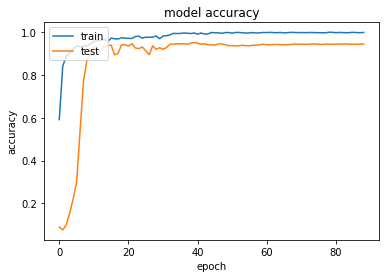

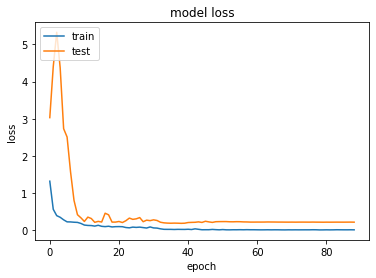

In [17]:
# plot everything
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
model = tf.keras.models.load_model('best_model_Skel2D.h5')
_, train_accuracy = model.evaluate(X_1, Y)
_, test_accuracy = model.evaluate(X_test_1, Y_test)

1960/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 3s 1ms/sample - loss: 0.0010 - acc: 0.9995


840/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [19]:
print('Accuracy on train set: {:.2f}%'.format(100 * train_accuracy))
print('Accuracy on test set: {:.2f}%'.format(100 * test_accuracy))

Accuracy on train set: 99.95%
Accuracy on test set: 95.24%


In [20]:
Y_pred = model.predict(X_test_1)
labels = ['Grab', 'Tap', 'Expand', 'Pinch', 'RC', 'RCC', 'SR', 'SL', 'SU', 'SD', 'SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

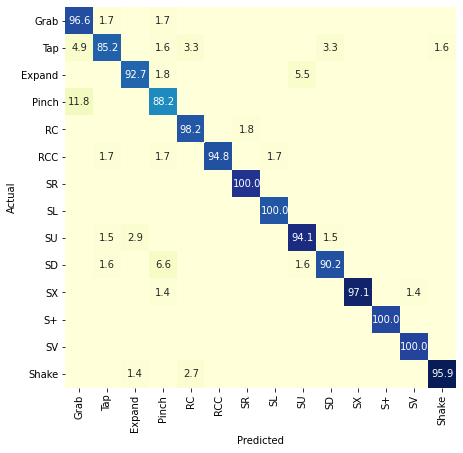

In [21]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_14.png', labels, ymap=None, figsize=(7,7))

In [22]:
Y_pred = model.predict(X_test_1)
labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

E:\Skelnet2D\SHREC\utils.py:83: RuntimeWarning: invalid value encountered in true_divide
  cm_perc = cm / cm_sum.astype(float) * 100


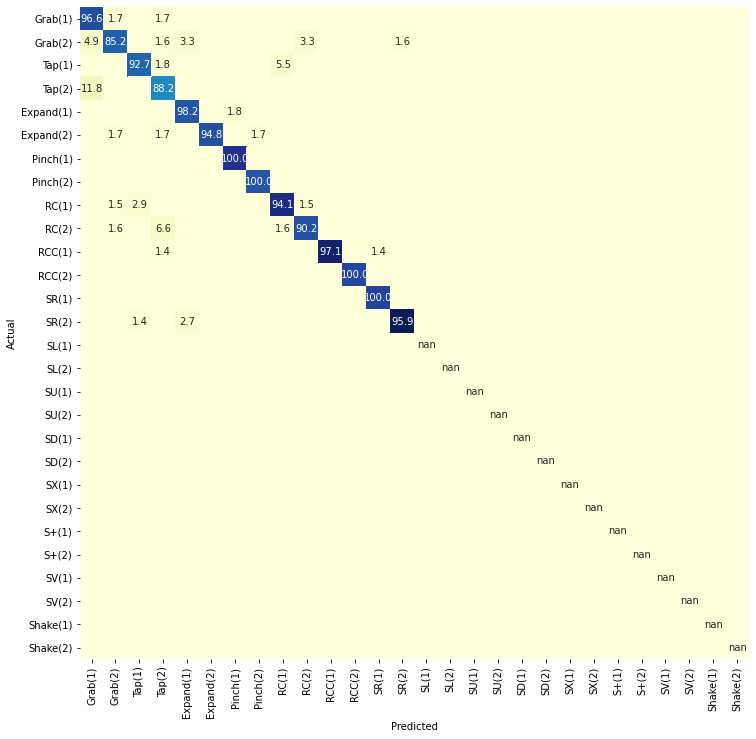

In [23]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_28.png', labels, ymap=None, figsize=(12,12))